In [ ]:
import os
import pandas as pd
import torch
import torchaudio
import torchaudio.transforms as T
import ast


# Configuration
AUDIO_DIR = "birdclef-2025/train_audio"
CSV_PATH = "birdclef-2025/train.csv"
PREPROCESSED_DIR = "preprocessed_segments"
SAMPLE_RATE = 32000
N_MELS = 128
DURATION = 5  # seconds
NUM_CLASSES = 207
BATCH_SIZE = 32
NUM_EPOCHS = 10

# Ensure output directory exists
os.makedirs(PREPROCESSED_DIR, exist_ok=True)

# Load and map labels
df = pd.read_csv(CSV_PATH)
all_labels = sorted(df["primary_label"].unique())
label2idx = {label: idx for idx, label in enumerate(all_labels)}

# Mel transforms
mel_transform = T.MelSpectrogram(
    sample_rate=SAMPLE_RATE,
    n_fft=1024,
    hop_length=320,
    n_mels=N_MELS
)
db_transform = T.AmplitudeToDB()
preprocess = False
if preprocess:
    # Preprocessing loop
    segments = []
    for _, row in df.iterrows():
        fname = row["filename"]
        file_path = os.path.join(AUDIO_DIR, fname)
        if not os.path.exists(file_path):
            continue

        try:
            waveform, sr = torchaudio.load(file_path)
            if sr != SAMPLE_RATE:
                resampler = T.Resample(sr, SAMPLE_RATE)
                waveform = resampler(waveform)
            if waveform.shape[0] > 1:
                waveform = torch.mean(waveform, dim=0, keepdim=True)

            total_len = waveform.shape[1]
            step = DURATION * SAMPLE_RATE
            num_chunks = total_len // step

            for i in range(num_chunks):
                chunk = waveform[:, i*step : (i+1)*step]
                mel = mel_transform(chunk)
                mel_db = db_transform(mel)
                mel_db = (mel_db - mel_db.mean()) / (mel_db.std() + 1e-6)

                target = torch.zeros(NUM_CLASSES)
                if row["primary_label"] in label2idx:
                    target[label2idx[row["primary_label"]]] = 1.0
                try:
                    sec_list = ast.literal_eval(row["secondary_labels"])
                    for label in sec_list:
                        if label in label2idx:
                            target[label2idx[label]] = 1.0
                except:
                    pass

            base_name = fname.replace('/', '_').replace('.ogg', '')
            out_name = f"{base_name}_{i}.pt"
            out_path = os.path.join(PREPROCESSED_DIR, out_name)

            torch.save({"mel": mel_db, "target": target}, out_path)
            segments.append(out_name)



        except Exception as e:
            print(f"Error processing {fname}: {e}")
else:
    pass

In [2]:
import os
import torch
from torch.utils.data import Dataset

class PreprocessedBirdCLEFDataset(Dataset):
    def __init__(self, file_list, data_dir):
        self.file_list = file_list
        self.data_dir = data_dir

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        sample_path = os.path.join(self.data_dir, self.file_list[idx])
        sample = torch.load(sample_path)
        return sample["mel"], sample["target"]


In [4]:
from sklearn.model_selection import train_test_split
import os

PREPROCESSED_DIR = "./preprocessed_segments"
all_files = [f for f in os.listdir(PREPROCESSED_DIR) if f.endswith(".pt")]

train_files, val_files = train_test_split(all_files, test_size=0.1, random_state=42)


In [5]:
train_dataset = PreprocessedBirdCLEFDataset(train_files, PREPROCESSED_DIR)
val_dataset = PreprocessedBirdCLEFDataset(val_files, PREPROCESSED_DIR)

from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)


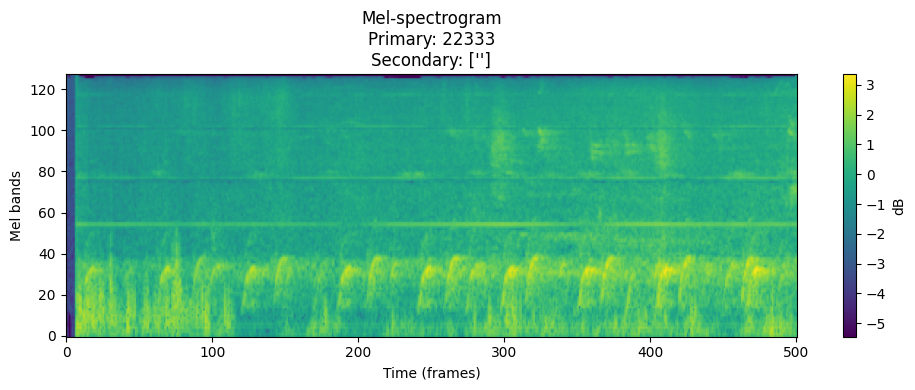

In [ ]:
import matplotlib.pyplot as plt

mel, target = train_dataset[138]

mel_np = mel.squeeze().numpy()  

# Визуализация
plt.figure(figsize=(10, 4))
plt.imshow(mel_np, origin='lower', aspect='auto', cmap='viridis')
plt.title(f"Mel-spectrogram\nPrimary: {df.iloc[138]['primary_label']}\nSecondary: {df.iloc[138]['secondary_labels']}")
plt.xlabel("Time (frames)")
plt.ylabel("Mel bands")
plt.colorbar(label="dB")
plt.tight_layout()
plt.show()


In [ ]:
import torch.nn as nn
import torch
from models.simplecnn import BirdCLEFClassifier, SimpleCNNEncoder

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BirdCLEFClassifier(SimpleCNNEncoder()).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.BCELoss()
NUM_EPOCHS = 10

for epoch in range(NUM_EPOCHS):
    model.train()
    train_loss = 0.0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        preds = model(x)
        loss = criterion(preds, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            preds = model(x)
            loss = criterion(preds, y)
            val_loss += loss.item()
    val_loss /= len(val_loader)

    print(f"Epoch {epoch+1}/{NUM_EPOCHS} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
